In [1]:
!pip install numpy pandas matplotlib scikit-learn qiskit qiskit-machine-learning qiskit_algorithms

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, copy, warnings
from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from IPython.display import clear_output

In [3]:
dataset_path = "creditcard.csv"
data = pd.read_csv(dataset_path)

In [4]:
normal = data[data.Class==0]
fraud = data[data.Class==1]
num_normal = normal.shape[0] 
num_fraud = fraud.shape[0] 
print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")
ratio = num_normal/num_fraud
print(f'normal to fraud ratio in the whole data = {round(ratio,2)}')

Number of normal examples = 284315
Number of fraud examples = 492

normal to fraud ratio in the whole data = 577.88


In [7]:
normal_fraud_ratio = 1
normal_sample = normal.sample(normal_fraud_ratio*num_fraud) 
sample = pd.concat([fraud, normal_sample], axis=0)  
for i in range(100):
    sample = np.random.permutation(sample)                  
X, y = sample[:,1:-1], sample[:,-1]
X = MinMaxScaler().fit_transform(X)
num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)

number of examples =  984
number of features =  29


In [10]:
n = int(np.ceil(np.log2(num_features)))
dim = 2**n
print(f'(number of qubits, dimension of the Hilbert space) = {(n, dim)}')
zeros = np.zeros((num_examples, dim-num_features))
X = np.append(X, zeros, axis=1)
num_examples, num_features = X.shape
num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)

(number of qubits, dimension of the Hilbert space) = (5, 32)
number of examples =  984
number of features =  32


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(688, 32) (296, 32)


In [12]:
fm = ZZFeatureMap(feature_dimension=num_features, reps=1)

In [13]:
fm = RawFeatureVector(feature_dimension=num_features) 

In [14]:
pqc = RealAmplitudes(num_qubits=n, reps=3)

In [15]:
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
optimizer = COBYLA(maxiter=50)
sampler = Sampler()
objective_func_vals = []
vqc = VQC(
    sampler=sampler,
    feature_map=fm,
    ansatz=pqc,
    optimizer=optimizer,
    callback=callback,
)

C:\Users\ghans\AppData\Local\Temp\ipykernel_5836\269055646.py:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


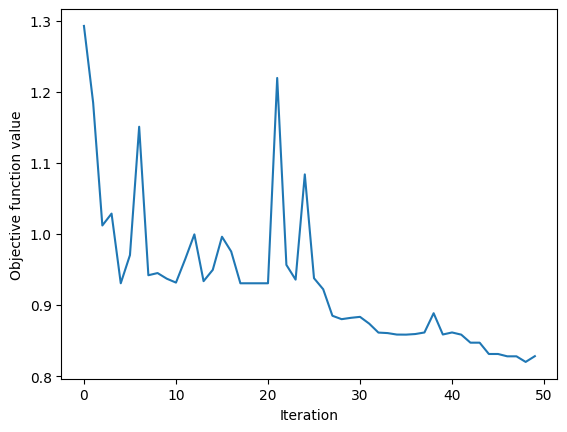

CPU times: total: 5min 46s
Wall time: 6min 27s


In [16]:
%%time
vqc.fit(X_train, y_train)

In [17]:
y_train_pred = vqc.predict(X_train)
y_test_pred = vqc.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n ")
print(round(roc_auc_score(y_test, y_test_pred),2), "= roc_auc_score for test set \n")

              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91       352
         1.0       0.98      0.81      0.88       336

    accuracy                           0.90       688
   macro avg       0.91      0.89      0.90       688
weighted avg       0.91      0.90      0.90       688

[[346   6]
 [ 65 271]] = confusion matrix for train set 

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       140
         1.0       0.97      0.84      0.90       156

    accuracy                           0.90       296
   macro avg       0.91      0.91      0.90       296
weighted avg       0.91      0.90      0.90       296

[[136   4]
 [ 25 131]] = confusion matrix for test set 
 
0.91 = roc_auc_score for test set 



In [18]:
%%time
warnings.filterwarnings('ignore')

def train_test(ML_model):
    print(20*' ', ML_model,'\n')
    ML_model.fit(X_train, y_train)                          # fit model
    
    y_train_pred = ML_model.predict(X_train)       # predict with the trained model
    y_test_pred = ML_model.predict(X_test)
    
    
    print(classification_report(y_train, y_train_pred))     # evaluate model performance 
    print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n")
    print(round(roc_auc_score(y_test, y_test_pred),2), "= roc_auc_score for test set \n")
    
    print(70*'=')
    

#----------------------------------------------------------------------------------

print(70*'=')
ML_model = linear_model.LogisticRegression()            # create model instance
train_test(ML_model)


ML_model = MLPClassifier()                            
train_test(ML_model)


ML_model = svm.SVC() 
train_test(ML_model)


ML_model = RandomForestClassifier()
train_test(ML_model)

                     LogisticRegression() 

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       352
         1.0       1.00      0.86      0.93       336

    accuracy                           0.93       688
   macro avg       0.94      0.93      0.93       688
weighted avg       0.94      0.93      0.93       688

[[351   1]
 [ 46 290]] = confusion matrix for train set 

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       140
         1.0       0.99      0.90      0.94       156

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.95      0.94      0.94       296

[[138   2]
 [ 15 141]] = confusion matrix for test set 

0.94 = roc_auc_score for test set 

                     MLPClassifier() 

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.94       352
   

In [19]:
import joblib
joblib.dump(vqc, 'vqc_model.pkl')

['vqc_model.pkl']

In [21]:
from sklearn.preprocessing import MinMaxScaler
import joblib

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']